# Mask-RCNN
this jupyter include Mask RCNN inference demo

In [80]:
# clone Mask RCNN code
!git clone  https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [86]:
!nvidia-smi

Fri Sep 28 09:04:45 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    57W / 149W |   5304MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [21]:
import timeit
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
print('tensorflow version', tf.__version__)  

tensorflow version 1.11.0-rc2


In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [0]:
ROOT_DIR = os.path.abspath("Mask_RCNN")

In [14]:
#prepare python modules 
!pip install cython
!pip install opencv-python
!pip install pycocotools
!pip install Pillow
!pip install imgaug

  Using cached https://files.pythonhosted.org/packages/96/84/9a07b1095fd8555ba3f3d519517c8743c2554a245f9476e5e39869f948d2/pycocotools-2.0.0.tar.gz
  Running setup.py bdist_wheel for pycocotools ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools


In [0]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# investigate Mask RCNN model



In [0]:
# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = "path to COCO dataset"  # TODO: enter value here

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [93]:
!unzip instances_minival2014.json.zip

Archive:  instances_minival2014.json.zip
  inflating: instances_minival2014.json  


In [94]:
!ls

2380_40.jpg    instances_minival2014.json      sample_data   wget-log.2
2380_40.jpg.1  instances_minival2014.json.zip  utils.py      wget-log.3
2380_40.jpg.2  Mask_RCNN		       visualize.py  wget-log.4
2380_40.jpg.3  model.py			       wget-log
coco.py        __pycache__		       wget-log.1


In [0]:
%matplotlib inline 

In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



In [96]:
%%time
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

CPU times: user 124 µs, sys: 0 ns, total: 124 µs
Wall time: 120 µs


In [0]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [23]:
!nvidia-smi | grep MiB

| N/A   32C    P8    28W / 149W |      0MiB / 11439MiB |      0%      Default |


In [24]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [25]:
%%time
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

CPU times: user 5.69 s, sys: 72.2 ms, total: 5.76 s
Wall time: 5.77 s


In [26]:
!nvidia-smi | grep MiB

| N/A   32C    P8    28W / 149W |      0MiB / 11439MiB |      0%      Default |


In [27]:
%%time
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 4.92 s, sys: 795 ms, total: 5.71 s
Wall time: 5.62 s


In [28]:
!nvidia-smi | grep MiB

| N/A   34C    P0    57W / 149W |    635MiB / 11439MiB |      0%      Default |


In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [0]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

In [75]:
%%time
# Run detection
results = model.detect([image], verbose=0)

CPU times: user 418 ms, sys: 151 ms, total: 569 ms
Wall time: 917 ms


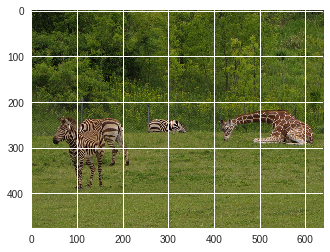

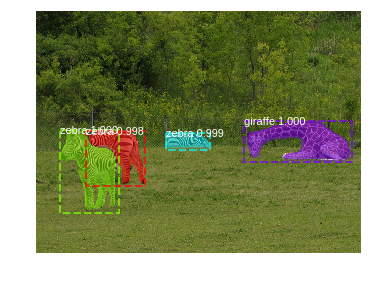

CPU times: user 581 ms, sys: 193 ms, total: 774 ms
Wall time: 555 ms


In [78]:
%%time
# Visualize results
r = results[0]
plt.imshow(image)
plt.show()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], figsize=(6, 6))

In [45]:
!wget http://weekly.chosun.com/up_fd/wc_news/2380/bimg_org/2380_40.jpg


Redirecting output to ‘wget-log.3’.


In [0]:
 %matplotlib inline
image2 = skimage.io.imread(os.path.join('./','2380_40.jpg'  ))

Processing 1 images
image                    shape: (400, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


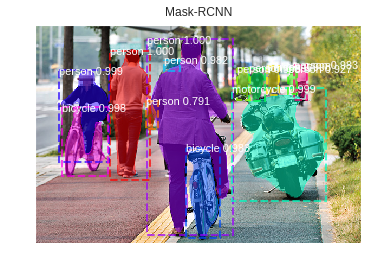

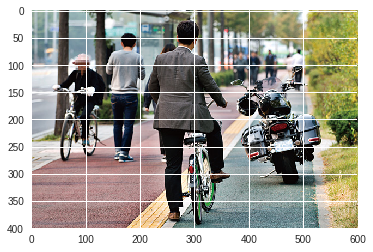

CPU times: user 1.51 s, sys: 510 ms, total: 2.02 s
Wall time: 1.92 s


In [68]:
%%time
# Run detection
results2 = model.detect([image2], verbose=1)
r2 = results2[0]
visualize.display_instances(image=image2, boxes=r2['rois'], masks=r2['masks'], class_ids=r2['class_ids'], class_names=class_names, scores=r2['scores'], title='Mask-RCNN', figsize=(6, 6)  )
plt.imshow(image2)
plt.show()